In [1]:
import re
from dataclasses import dataclass
from typing import List

In [2]:
from autogen_core import DefaultTopicId, MessageContext, RoutedAgent, default_subscription, message_handler
from autogen_core.code_executor import CodeBlock, CodeExecutor
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)

In [3]:
@dataclass
class Message:
    content: str

In [4]:
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. Assume the required packages does not exist and have to be installed.
3. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

In [5]:
@default_subscription
class Assistant(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("An assistant agent.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content=code_writer_system_message
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\nAssistant:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))  # type: ignore
        await self.publish_message(Message(content=result.content), DefaultTopicId())  # type: ignore


def extract_markdown_code_blocks(markdown_text: str) -> List[CodeBlock]:
    pattern = re.compile(r"```(?:\s*([\w\+\-]+))?\n([\s\S]*?)```")
    matches = pattern.findall(markdown_text)
    code_blocks: List[CodeBlock] = []
    for match in matches:
        language = match[0].strip() if match[0] else ""
        code_content = match[1]
        code_blocks.append(CodeBlock(code=code_content, language=language))
    return code_blocks

In [6]:
@default_subscription
class Executor(RoutedAgent):
    def __init__(self, code_executor: CodeExecutor) -> None:
        super().__init__("An executor agent.")
        self._code_executor = code_executor

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        code_blocks = extract_markdown_code_blocks(message.content)
        if code_blocks:
            result = await self._code_executor.execute_code_blocks(
                code_blocks, cancellation_token=ctx.cancellation_token
            )
            print(f"\n{'-'*80}\nExecutor:\n{result.output}")
            await self.publish_message(Message(content=result.output), DefaultTopicId())

In [ ]:
import tempfile
import os
from dotenv import load_dotenv
load_dotenv()

from autogen_core import SingleThreadedAgentRuntime
from autogen_ext.code_executors.docker import DockerCommandLineCodeExecutor
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [29]:
# Create an local embedded runtime.
runtime = SingleThreadedAgentRuntime()

In [ ]:
async with DockerCommandLineCodeExecutor(work_dir="coding") as executor:  # type: ignore[syntax]
    # Register the assistant and executor agents by providing
    # their agent types, the factory functions for creating instance and subscriptions.

    custom_model_client = OpenAIChatCompletionClient(
        model="openai/gpt-4.1",
        base_url="https://models.github.ai/inference",
        api_key= os.getenv("GITHUB_TOKEN"),
        model_info={
            "vision": True,
            "function_calling": True,
            "json_output": True,
            "family": "unknown",
            "structured_output": True,
        },
    )

    await Assistant.register(
        runtime,
        "assistant",
        lambda: Assistant(model_client=custom_model_client),
    )
    await Executor.register(runtime, "executor", lambda: Executor(executor))

    # Start the runtime and publish a message to the assistant.
    runtime.start()
    await runtime.publish_message(
        Message("Create a plot of NVIDA vs TSLA stock returns YTD from 2024-01-01., and save it in a file gains"), DefaultTopicId()
    )

    # Wait for the runtime to stop when idle.
    await runtime.stop_when_idle()
    # Close the connection to the model client.
    await custom_model_client.close()

C:\Users\nithy\AppData\Local\Temp\ipykernel_17376\1333090110.py:15: UserWarning: Resolved model mismatch: openai/gpt-4.1 != gpt-4.1-2025-04-14. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4.1-2025-04-14 to enhance token/cost estimation and suppress this warning.
  result = await self._model_client.create(self._chat_history)



--------------------------------------------------------------------------------
Assistant:
Plan:

1. Install necessary packages (yfinance for downloading stock data, pandas for data manipulation, matplotlib for plotting).
2. Download YTD (Year-To-Date) stock price data for NVIDIA (NVDA) and Tesla (TSLA) from 2024-01-01 to the current date.
3. Calculate daily returns for both stocks and plot cumulative returns.
4. Save the figure to a file named gains.png.

Let's proceed with the code.

```python
# filename: plot_nvidia_tsla_ytd.py
import sys
import subprocess

# Function to install packages if not already installed
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import yfinance as yf
except ImportError:
    install('yfinance')
    import yfinance as yf

try:
    import matplotlib.pyplot as plt
except ImportError:
    install('matplotlib')
    import matplotlib.pyplot as plt

try:
    import pandas as pd
except ImportError:


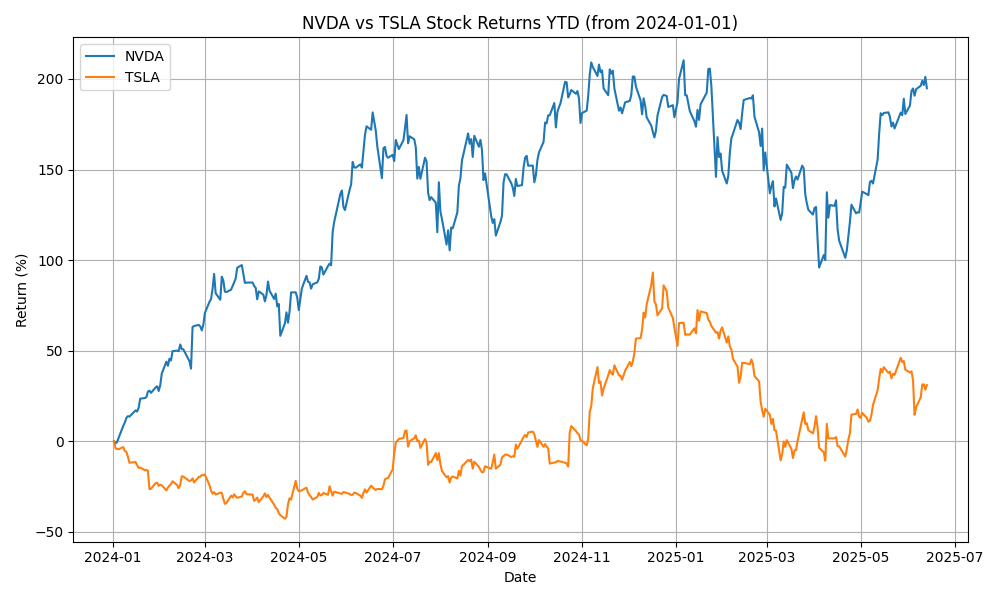

In [20]:
from IPython.display import Image

Image(filename=f"coding/gains.png")  # type: ignore